In [1]:
import os
import zipfile

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Imputation libraries
import scprep # preprocessing
import saver
import magic
import scanpy as sc

from scipy.stats import spearmanr

# Clustering libraries
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import anndata
import scanpy.external as sce
import harmonypy

from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score
#https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_04_clustering.html

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 0: Load data with scanpy

In [2]:
path_data = "data/"
results_path = "results"
archive_name = "CarballoCastro_Alba.zip"

In [3]:
#Read the bulk and set gene names as variables and patients as observations

bulk_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).set_index("level_0")
bulk = sc.read(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).transpose()
bulk.var['gene_id'] = bulk_pancreas.index
bulk.obs ['patient_id'] = bulk_pancreas.columns
bulk.var_names_make_unique()

In [4]:
#Now I read the single cell data and metadata
sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")
sc_pancreas_metadata = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_metadata_train.csv")).set_index("Source Name")
sc_train = sc.read(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).transpose()
sc_train.var['gene_id'] = sc_pancreas.index
sc_train.obs['cell_id'] = sc_pancreas.columns
sc_train.obs['cell_type']= sc_pancreas_metadata['Celltype']
sc_train.var_names_make_unique()

# I also read the single cell test data and metadata

sc_pancreas_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).set_index("Unnamed: 0")
sc_pancreas_metadata_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_metadata_test_wocelltype.csv")).set_index("Source Name")

sc_test = sc.read(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).transpose()
sc_test.var['gene_id'] = sc_pancreas_test.index
sc_test.obs['cell_id'] = sc_pancreas_test.columns
sc_test.var_names_make_unique()

In [ ]:
print(f"Number of patients in the train dataset {bulk.X.shape[0]}")

print(f"Number of genes in the dataset {bulk.X.shape[1]}")

assert bulk.X.shape[1] == sc_train.X.shape[1]
print(f"Number of cells in the train dataset {sc_train.X.shape[0]}")

In [ ]:
print(f"Number of cells in the test dataset {sc_test.X.shape[0]}")

In [ ]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}")

In [ ]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease==dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

In [ ]:
print(f"There are {sc_pancreas_metadata.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {sc_pancreas_metadata.Celltype.unique()}")

In [ ]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}")

In [ ]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease==dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

# Step 1: Data preprocessing

In [ ]:
# For the imputation, we need to have the data log transformed
sc.pp.log1p(bulk)
sc.pp.log1p(sc_train)
sc.pp.log1p(sc_test)


# Step 2: Perform the imputation

### Data preprocessing

* Filtering: we see that data is prefiltered
* Removing unexpressed genes? -> MAGIC recomienda pero según las guidelines no se debe eliminar ningún gen

In [ ]:
scprep.plot.plot_library_size(sc_train.X.transpose(), cutoff=5000)

### Imputation using MAGIC

In [ ]:
magic_op = magic.MAGIC()

In [ ]:
#Apply MAGIC in the whole training data
sc_magic = magic_op.fit_transform(sc_train.X)

In [ ]:
#We will create the bulkified matrix to compare the bulk with the imputed data.
#In the bulk matrix we just have one measurement per patient per gene. 
#In the sc data we need to compute the average over each cell for each patient and gene

assert sc_pancreas_metadata.shape[0] == sc_magic.shape[0]


In [ ]:
#We will create the bulkified matrix to compare the bulk with the imputed data.
#In the bulk matrix we just have one measurement per patient per gene. 
#In the sc data we need to compute the average over each cell for each patient and gene

assert sc_pancreas_metadata.shape[0] == sc_magic.shape[0]
df_magic = pd.DataFrame(sc_magic, index= sc_pancreas_metadata.index, columns= sc_train.var['gene_id'])
train_merged = sc_pancreas_metadata.join(df_magic, on='Source Name')
train_bulkified = train_merged.groupby('Sample', as_index= False).mean()
train_bulkified.drop(train_bulkified.columns[0],axis=1, inplace=True)
train_bulkified.index = ["patient1","patient2","patient3","patient4"]
print(f'Train bulkified matrix shape is : {train_bulkified.shape}')
print(f'Train bulk matrix shape is : {bulk.X.shape}')

#I will transpose them so that they agree with the previous dimensions just in case
train_bulkified_t = train_bulkified.transpose()
bulk_t = bulk.transpose()

print(f'Transposed train bulkified matrix shape is : {train_bulkified_t.shape}')
print(f'Transposed train bulk matrix shape is : {bulk_t.X.shape}')

### Performance evaluation: Spearman

In [ ]:
# MAGIC
corr, pval = spearmanr(bulk_t.X, train_bulkified_t)
spearman = corr.mean()
print(f'Spearman correlation for train is {spearman}')

In [ ]:
#TODO: train magic with all the train data, predict on test and provide the file in the final format


# Step 3: Perform clustering 

## Trial of clustering UMAP

In [28]:
import umap
import hdbscan
import sklearn.cluster as cluster

In [29]:
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=1.0,
    n_components=2,
    random_state=42,
).fit_transform(sc_pancreas.transpose())

In [31]:
sc_train.obsm['X_umap'].shape

(978, 2)

In [45]:
labels = hdbscan.HDBSCAN(
    min_samples=20,
    min_cluster_size=80,
).fit_predict(sc_train.obsm['X_umap'])
clustered = (labels >= 0)
clustered.sum()
labels

array([ 2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  1,  0,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  2,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [ ]:
pca_ob = PCA(n_components=50)
pca_matrix_50 = sc_train.obsm['X_pca']

# Code by parts

In [48]:
#Load sc train
sc.settings.verbosity = 3 
sc_train = sc.read(os.path.join(path_data,"train_data","pancreas_sc_train.csv"), cache=True).transpose()
sc_train.var['gene_id'] = sc_pancreas.index
sc_train.obs['cell_id'] = sc_pancreas.columns
sc_train.obs['cell_type']= sc_pancreas_metadata['Celltype']
sc_train.var_names_make_unique()
sc.pp.log1p(sc_train)
sc_train.obs['batch']= sc_pancreas_metadata['Disease']
sc_train.obs['patient']= sc_pancreas_metadata['Sample']
sc_train.var_names_make_unique()

... reading from cache file cache/data-train_data-pancreas_sc_train.h5ad


In [49]:
sc.pp.filter_cells(sc_train, min_genes=200)
sc.pp.filter_genes(sc_train, min_cells=2)

# sc.pp.normalize_total(sc_train, target_sum=1e4)
sc.pp.normalize_per_cell(sc_train, counts_per_cell_after=1e4)
#matrix = sc_train.X. Worse performance with square root
#sqrt_matrix = np.sqrt(matrix)
#sc_train.X = sqrt_matrix
sc.pp.log1p(sc_train, base = 10)
sc.pp.highly_variable_genes(sc_train, n_top_genes=2500)
sc_train.raw = sc_train
sc_train = sc_train[:, sc_train.var.highly_variable]
sc.pp.scale(sc_train, max_value=10)


filtered out 4802 genes that are detected in less than 2 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [50]:
sc_train.var_names

Index(['DBT', 'EYA3', 'SFPQ', 'RAB3B', 'LEPR', 'ST6GALNAC3', 'LRRC8C', 'RHOC',
       'DNM3', 'BRINP2',
       ...
       'GRAP2', 'LOC101927257', 'MCHR1', 'MEI1', 'SEPT3', 'NDUFA6', 'SAMM50',
       'PKDREJ', 'GTSE1-AS1', 'LOC642757'],
      dtype='object', length=2500)

In [51]:
#sc.tl.pca(sc_train, n_comps = 200 )
#sce.pp.harmony_integrate(sc_train, 'batch')
# sc.tl.pca(sc_train, n_comps= 250)
# sc.external.pp.bbknn(sc_train, batch_key='batch', n_pcs=250)
sc.pp.neighbors(sc_train, n_neighbors=40, use_rep='X')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


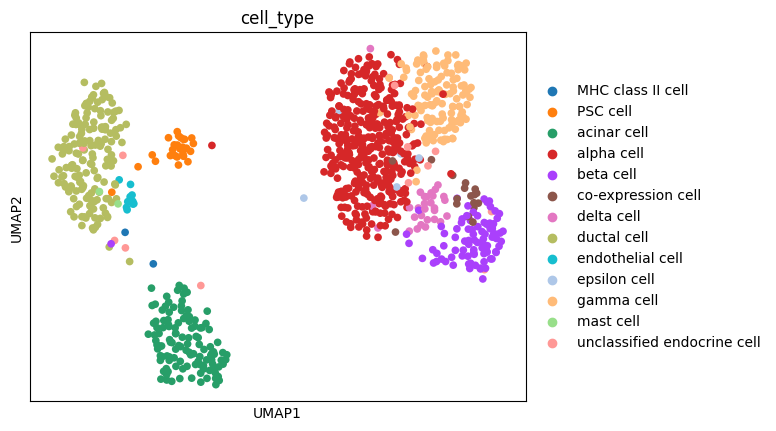

In [52]:
sc.tl.umap(sc_train)
sc.pl.umap(sc_train, color=['cell_type'])

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


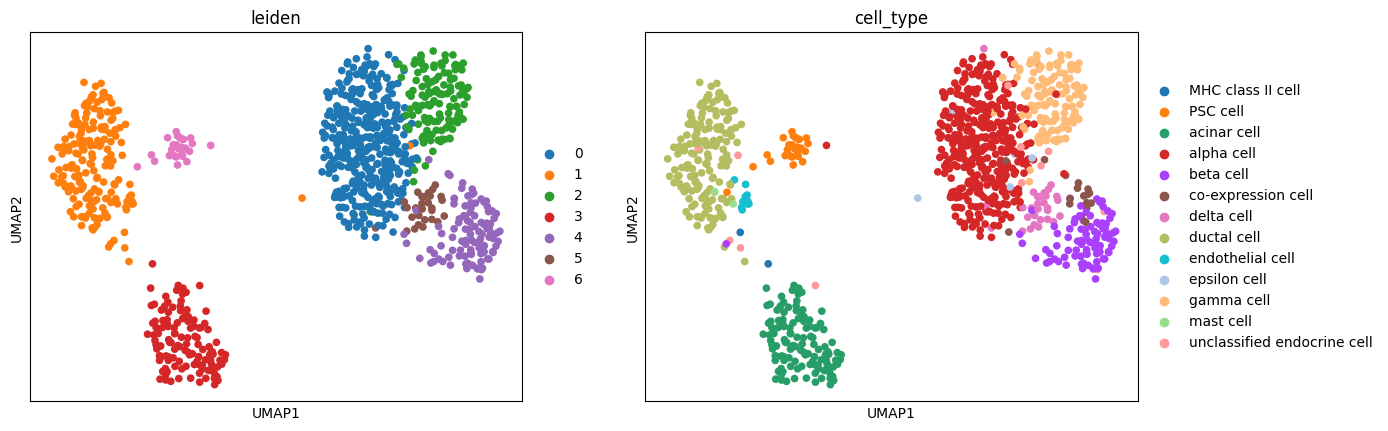

In [53]:
sc.tl.leiden(sc_train, resolution=1.4, random_state=42)
sc.pl.umap(sc_train, color=['leiden', 'cell_type'])

In [56]:
#Obtain labels from leiden clustering
leiden_labels = sc_train.obs['leiden']
leiden_l = np.empty((978,), dtype=int)
for i in range(978):
    value= leiden_labels[i]
    leiden_l[i]= value

#Compute PCA space to evaluate silhuoette coefficient
sc.tl.pca(sc_train, n_comps= 50)
pca_matrix_50 = sc_train.obsm['X_pca']

# pca = PCA(n_components=50)
# pca_matrix_50 = pca.fit_transform(sc_train.X)


#Encode the true labels

cell_labels = sc_pancreas_metadata['Celltype']
encoder = LabelEncoder()
encoded_label = encoder.fit_transform(cell_labels)

ssc = silhouette_score(pca_matrix_50, leiden_labels)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(encoded_label, leiden_labels)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(encoded_label, leiden_labels)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
Silhouette score: 0.24030371
Adjusted Rand Index: 0.8943709662893026
V-Measure score: 0.8720962556895763
Performance: 0.6689236440273045


### Code complete

In [ ]:
#Load sc train

neighbours= range(5,50)
res= np.arange(0.1, 2.1, 0.1)
results=[]
for neigh in neighbours:
    for resolution in res:
        #sc.settings.verbosity = 3 
        sc_train = sc.read(os.path.join(path_data,"train_data","pancreas_sc_train.csv"), cache=True).transpose()
        sc_train.var['gene_id'] = sc_pancreas.index
        sc_train.obs['cell_id'] = sc_pancreas.columns
        sc_train.obs['cell_type']= sc_pancreas_metadata['Celltype']
        sc_train.var_names_make_unique()
        sc.pp.log1p(sc_train)
        sc_train.obs['batch']= sc_pancreas_metadata['Disease']
        sc_train.obs['patient']= sc_pancreas_metadata['Sample']
        sc_train.var_names_make_unique()

        sc.pp.filter_cells(sc_train, min_genes=200)
        sc.pp.filter_genes(sc_train, min_cells=2)
        sc.pp.normalize_total(sc_train, target_sum=1e4)
        sc.pp.log1p(sc_train, base=10)
        sc_train.raw = sc_train
        sc.pp.highly_variable_genes(sc_train, n_top_genes=700)
        sc_train = sc_train[:, sc_train.var.highly_variable]
        sc.pp.scale(sc_train)

        sc.pp.neighbors(sc_train, n_neighbors=neigh, use_rep='X')
        sc.tl.leiden(sc_train, resolution=resolution, random_state=42)

        #Obtain labels from leiden clustering
        leiden_labels = sc_train.obs['leiden']
        leiden_l = np.empty((978,), dtype=int)
        for i in range(978):
            value= leiden_labels[i]
            leiden_l[i]= value

        #Compute PCA space to evaluate silhuoette coefficient
        sc.tl.pca(sc_train, n_comps= 50)
        pca_matrix_50 = sc_train.obsm['X_pca']

        #Encode the true labels

        cell_labels = sc_pancreas_metadata['Celltype']
        encoder = LabelEncoder()
        encoded_label = encoder.fit_transform(cell_labels)

        ssc = silhouette_score(pca_matrix_50, leiden_l)
        #print('Silhouette score:', ssc)

        ari = adjusted_rand_score(encoded_label, leiden_l)
        #print('Adjusted Rand Index:', ari)

        v_measure = v_measure_score(encoded_label, leiden_l)
        #print('V-Measure score:', v_measure)

        performance = (1/3)*(ssc + ari + v_measure)
        #print('Performance:', performance)
        results.append([neigh, resolution, ssc, ari,v_measure, performance])

In [ ]:
df_2= pd.DataFrame(results, columns=['neigh', 'resolution', 'ssc', 'ari', 'v', 'total'])
df_2.sort_values(by='total', ascending=False)

In [ ]:
neigh=3
sc.pp.neighbors(sc_train, n_neighbors=neigh, use_rep='X')

### PCA dimensionality reduction

In [ ]:
sc.tl.pca(sc_imput, n_comps = 60 )

In [ ]:
sce.pp.harmony_integrate(sc_imput, 'batch')

### Graph constructing for clustering

In [ ]:
sc_imput.obsm['X_pca'] = sc_imput.obsm['X_pca_harmony']


In [ ]:
sc.pp.neighbors(sc_imput, n_neighbors=35, n_pcs=30)

In [ ]:
sc.tl.umap(sc_imput)
sc.pl.umap(sc_imput, color=['cell_type', 'batch'])

In [ ]:
sc.tl.umap(sc_imput)
sc.pl.umap(sc_imput, color=['cell_type', 'batch'])

In [ ]:
sc.tl.leiden(sc_imput, resolution = 0.27)
sc.pl.umap(sc_imput, color=['leiden', 'batch'])

In [ ]:
#Obtain labels from leiden clustering
leiden_labels = sc_imput.obs['leiden']
leiden_l = np.empty((978,), dtype=int)
for i in range(978):
    value= leiden_labels[i]
    leiden_l[i]= value

In [ ]:
#Compute PCA space to evaluate silhuoette coefficie
sc.tl.pca(sc_imput, n_comps= 50)
pca_matrix_50 = sc_imput.obsm['X_pca']

In [ ]:
#Encode the true labels

cell_labels = sc_pancreas_metadata['Celltype']
encoder = LabelEncoder()
encoded_label = encoder.fit_transform(cell_labels)
#decoded_label = encoder.inverse_transform(encoded_label)

In [ ]:
ssc = silhouette_score(pca_matrix_50, leiden_l)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(encoded_label, leiden_l)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(encoded_label, leiden_l)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

In [ ]:
ssc = silhouette_score(pca_matrix_50, leiden_l)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(encoded_label, leiden_l)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(encoded_label, leiden_l)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

### PCA Dataframe

In [ ]:
PCA_df = pd.DataFrame(data = pancreas_pca, columns = ["PC"+str(i+1) for i in range(50)])
print(PCA_df.shape)
PCA_df.insert(loc=0, column='index', value=sc_pancreas_shuff.columns)
print(PCA_df)

### Scanpy tutorial for clustering on NOT imputed data

In [ ]:
sc.pp.log1p(sc_pancreas_t)
sc_pancreas_t.raw = sc_pancreas_t

In [ ]:
sc.tl.pca(sc_pancreas_t, n_comps= 20)

In [ ]:
sc.pp.neighbors(sc_pancreas_t, n_neighbors=10, n_pcs=20)

In [ ]:
sc.tl.umap(sc_pancreas_t)

In [ ]:
sc.pl.umap(sc_pancreas_t,use_raw=True)

In [ ]:
sc.tl.leiden(sc_pancreas_t, resolution =0.40005)

In [ ]:
sc.pl.umap(sc_pancreas_t, color=['leiden', 'cell_type'])

In [ ]:
#Obtain labels from leiden clustering
leiden_labels = sc_pancreas_t.obs['leiden']
leiden_l = np.empty((978,), dtype=int)
for i in range(978):
    value= leiden_labels[i]
    leiden_l[i]= value


In [ ]:
#Compute PCA space to evaluate silhuoette coefficie
sc.tl.pca(sc_pancreas_t, n_comps= 50)
pca_matrix_50 = sc_pancreas_t.obsm['X_pca']
#El resultado es

In [ ]:
ssc = silhouette_score(pca_matrix_50, leiden_l)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(encoded_label, leiden_l)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(encoded_label, leiden_l)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

# Step 3: Predict on the test data

Cuando decidamos qué tecnicas de imputación y clustering son mejores, hacerlo en los datos de test.

# Step 4: Save the required files

In [ ]:
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
# bulkified.columns = ["patient5","patient6","patient7"]
# bulkified.index = sc_pancreas_test.index

In [ ]:
# assert all(bulkified.columns == ["index","patient5","patient6","patient7"])
# assert all(bulkified["index"] == sc_pancreas_test.index)

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = sc_pancreas_test.columns

In [ ]:
# assert all(cluster_labels.columns == ["index","cluster"])
# assert all(cluster_labels["index"] == sc_pancreas_test.columns)

In [ ]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [ ]:
# assert all(PCA.columns == ["index"] + ["PC"+str(i+1) for i in range(50)])
# assert all(PCA["index"] == sc_pancreas_test.columns)

In [ ]:
# with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
#     with zf.open(f"imputed_bulkified.csv", "w") as buffer:
#         bulkified.to_csv(buffer)
#     with zf.open(f"cluster_membership.csv", "w") as buffer:
#         cluster_labels.to_csv(buffer)
#     with zf.open(f"PCA.csv", "w") as buffer:
#         PCA.to_csv(buffer)
#     zf.close()

In [ ]:
# archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
# assert all(
#         [
#             i in archive.namelist()
#             for i in [
#                 "imputed_bulkified.csv",
#                 "cluster_membership.csv",
#                 "PCA.csv",
#             ]
#         ]
#     )